In [1]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.appName("weapon").getOrCreate()

In [2]:
spark

In [27]:
kill1 = spark.read.parquet('s3://502pubg/clean/kill1.parquet')
# read data

In [47]:
kill1.show(5)

+------------+----------------+-----------------+-----------------+-------+----+----------------+-----------------+-----------------+------------------+-----------+--------+--------------------+--------------------+
|   killed_by|killer_placement|killer_position_x|killer_position_y|    map|time|victim_placement|victim_position_x|victim_position_y|              DIST|weaponindex|mapindex|            features|         stdfeatures|
+------------+----------------+-----------------+-----------------+-------+----+----------------+-----------------+-----------------+------------------+-----------+--------+--------------------+--------------------+
|Down and Out|             1.0|           176803|           323455|ERANGEL|1675|             5.0|           170991|           346383| 23653.17162665506|        0.0|     0.0|[176803.0,323455....|[1.24029993660454...|
|         P92|            15.0|           467150|           640876|ERANGEL|  94|            23.0|           467290|           640992| 18

In [17]:
kill1.printSchema()

root
 |-- killed_by: string (nullable = true)
 |-- killer_placement: double (nullable = true)
 |-- killer_position_x: integer (nullable = true)
 |-- killer_position_y: integer (nullable = true)
 |-- map: string (nullable = true)
 |-- time: integer (nullable = true)
 |-- victim_placement: double (nullable = true)
 |-- victim_position_x: integer (nullable = true)
 |-- victim_position_y: integer (nullable = true)
 |-- DIST: double (nullable = true)
 |-- weaponindex: double (nullable = true)
 |-- mapindex: double (nullable = true)
 |-- features: vector (nullable = true)
 |-- stdfeatures: vector (nullable = true)



In [24]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

In [49]:
weapon = kill1.select('weaponindex','DIST').toPandas()

In [50]:
## take a log of the distance
weapon["DIST"] = np.log10(1 + weapon["DIST"])
weapon

,weaponindex,DIST
0,2.0,2.398066
1,0.0,3.746711
2,21.0,3.728080
3,0.0,3.114942
4,7.0,5.902688
...,...,...
58923971,12.0,2.682169
58923972,4.0,2.650774
58923973,7.0,3.756819
58923974,8.0,5.916535


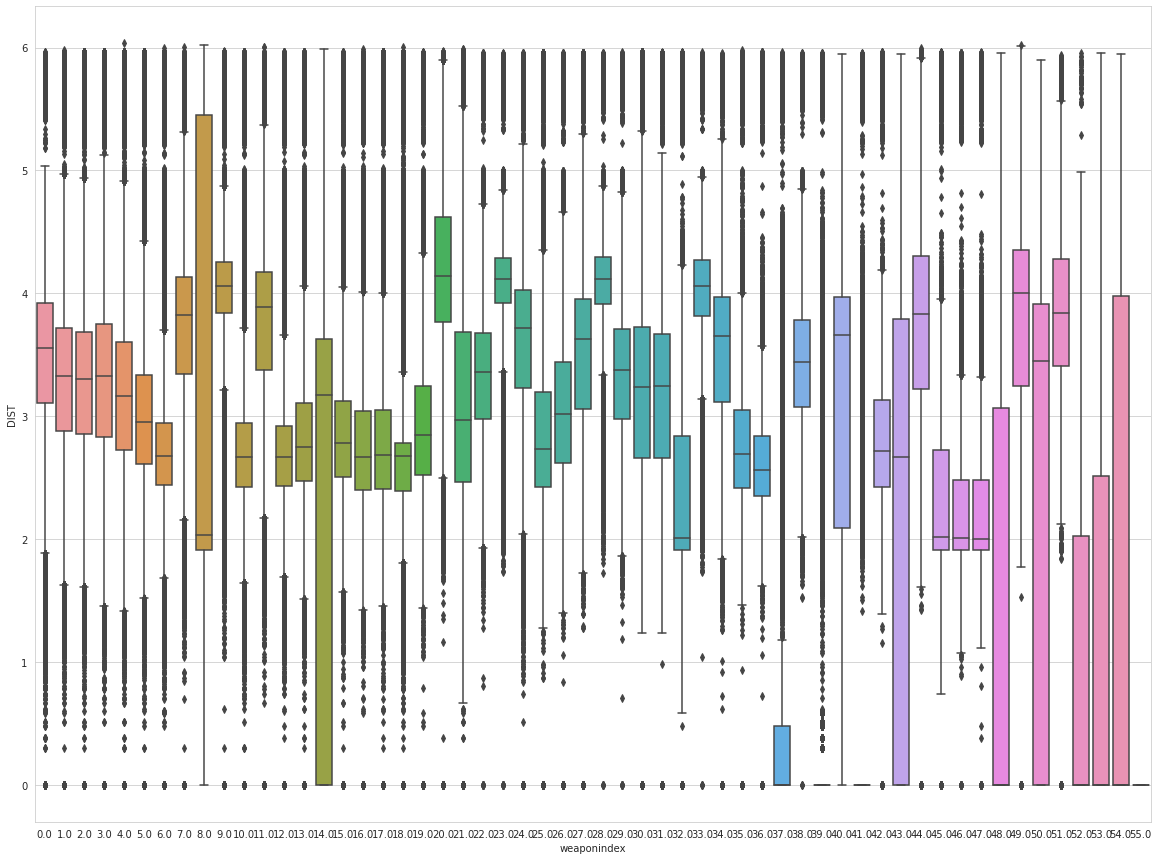

In [53]:
plt.figure(figsize=(20,15))
sns.set_style("whitegrid") 
sns.boxplot(x='weaponindex',y='DIST',data=weapon)
plt.show()
#Boxplot of the weapon vs time

In [52]:
final_kills = kill1.select('killed_by').toPandas()

## Logistic Regression

In [64]:
from pyspark.ml import Pipeline
from pyspark.sql.functions import when,col
from pyspark.ml.feature import OneHotEncoder, StringIndexer, IndexToString, VectorAssembler, StandardScaler
from pyspark.ml.classification import LogisticRegression

In [71]:
# logistic regression
vectorAssembler_features = VectorAssembler(
    inputCols=['killer_placement','killer_position_x','killer_position_y','victim_position_x','victim_position_y','DIST','time','mapindex'], 
    outputCol="features",handleInvalid="skip")
#scale features
scal = StandardScaler(inputCol='features',outputCol='stdfeatures',withStd=True, withMean=False)

fit=LogisticRegression(labelCol='weaponindex', featuresCol="features")

In [72]:
df = kill1.select('killed_by','killer_placement','killer_position_x','killer_position_y','victim_position_x','victim_position_y','DIST','time','weaponindex','mapindex')
train_df, test_df = df.randomSplit([0.7, 0.3])

In [73]:
# start pipeline
pipeline = Pipeline(stages=[vectorAssembler_features, 
                            scal,
                            fit])

In [74]:
logistic_std = pipeline.fit(train_df)

KeyboardInterrupt: 

In [75]:
spark.stop()